In [1]:
import time
import os
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
import pickle as pkl
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df = 0.0005)

In [2]:
class_mapping = {}
with open('../dbpedia_csv/classes.txt') as txt_file:
    line_num = 1
    for line in txt_file:
        class_mapping[line_num-1] = line.strip()
        line_num+=1
        
print(class_mapping)

{0: 'Company', 1: 'EducationalInstitution', 2: 'Artist', 3: 'Athlete', 4: 'OfficeHolder', 5: 'MeanOfTransportation', 6: 'Building', 7: 'NaturalPlace', 8: 'Village', 9: 'Animal', 10: 'Plant', 11: 'Album', 12: 'Film', 13: 'WrittenWork'}


### Load data to train Tf-Idf

In [ ]:
train_data = pd.read_csv('../dbpedia_csv/train.csv', header = -1, names = ['ClassIndex', 'Title', 'Content'])
test_data = pd.read_csv('../dbpedia_csv/test.csv', header = -1, names = ['ClassIndex', 'Title', 'Content'])

In [ ]:
tempXtrain = train_data['Content'].tolist()
tempytrain = train_data['ClassIndex'].tolist()
Xtrain = []
ytrain = []
for i in range(14):
    Xtrain.extend(tempXtrain[i*40000:(i*40000+30000)])
    ytrain.extend(tempytrain[i*40000:(i*40000+30000)])
del train_data,tempXtrain,tempytrain

In [ ]:
stemmer = PorterStemmer()

def process(data):
    processed = []
    for item in data:
        item = item.lower()
        item = word_tokenize(item)
        for i in range(len(item)):
            item[i] = stemmer.stem(item[i])
        processed.append(' '.join(item))
    return processed

In [ ]:
Xtrain = process(Xtrain)
test_data['ProcessedContent'] = process(test_data['Content'])

In [ ]:
Xtest = test_data['ProcessedContent'].tolist()
ytest = test_data['ClassIndex'].tolist()
del test_data

### Fit Tf-Idf to this data

In [ ]:
Xtrain = vectorizer.fit_transform(Xtrain).toarray()
Xtest = vectorizer.transform(Xtest).toarray()

In [ ]:
pkl.dump(vectorizer, open('TfIdfVectorizer', 'wb'))

In [ ]:
import numpy as np
np.save(open('TfIdfTraining_data', 'wb'), Xtrain)
np.save(open('TfIdfTraining_labels', 'wb'), ytrain)
np.save(open('TfIdfTesting_data', 'wb'), Xtest)
np.save(open('TfIdfTesting_labels', 'wb'), ytest)

### Fit Multinomial Naive Bayes to this data

In [ ]:
multinomialNB = MultinomialNB().fit(Xtrain,ytrain)

In [ ]:
pkl.dump(multinomialNB, open('MultinomialNB', 'wb'))

## Sequential Testing

In [ ]:
vectorizer = pkl.load(open('TfIdfVectorizer', 'rb'))

In [ ]:
start = time.time()
accuracies = {}
for label in os.listdir('../Testing'):
    accuracies[label] = {}
    for sent_len in os.listdir('../Testing/{}/'.format(label)):
        Xtest = []
        labels = []
        if int(sent_len) <= 100:
            for file in os.listdir('../Testing/{}/{}/'.format(label,sent_len)):
                sample = pkl.load(open('../Testing/{}/{}/{}'.format(label,sent_len,file), 'rb'))
                labels.append(sample[0])
                Xtest.append(' '.join(process(sample[1])))
            Xtest = vectorizer.transform(Xtest).toarray()
            result = multinomialNB.predict(Xtest)
            accuracy = np.sum(result == labels)/len(labels)
            accuracies[label][sent_len] = accuracy
    print('elapsed time: {}'.format((time.time()-start)/60))
pkl.dump(accuracies, open('TfIdf_Accuracy', 'wb'))

In [3]:
accs = pkl.load(open('TfIdf_Accuracy', 'rb'))

In [4]:
accuracies = pd.DataFrame([accs[key] for key in accs.keys()]).rename(index = class_mapping)
accuracies = accuracies.reindex(sorted(list(accuracies.columns), key = int), axis = 1).transpose()
accuracies['Total Accuracy'] = accuracies.sum(axis=1)/14
accuracies['Number of Words'] = accuracies.index.astype(int)

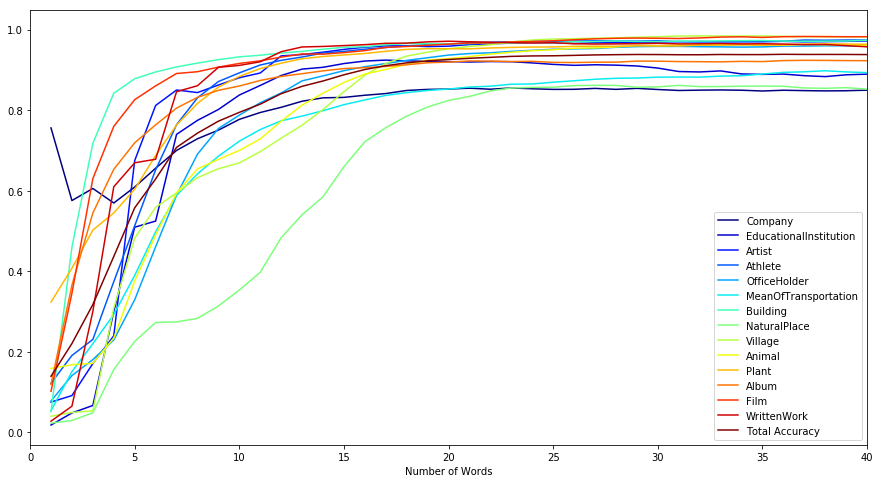

In [5]:
accuracies.plot(x ='Number of Words', figsize = (15,8), xlim=(0,40), colormap = 'jet')
plt.show()

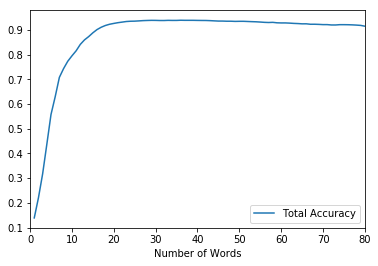

In [6]:
accuracies.plot(x = 'Number of Words', y = 'Total Accuracy', xlim=(0,80))
plt.show()